# Mini Project 2021

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [41]:
import warnings;
warnings.filterwarnings('ignore');

## Q1 SQL Database
#### Connect to the MySQL database which has a table of samples of the historical Freddie Mac singlefamily loan level data.

The following shows the connection details

In [42]:
## Q1
## input details to connect with the database

import mysql.connector

db=mysql.connector.connect(
    host="miniproject-qfa.cef17qxjlavg.us-west-2.rds.amazonaws.com",
    port=3306,
    user="newuser",
    passwd="unisonim2.0",
    database="AgencyData"
)

## check the connection
print(db)

The following is a list of databases fetched from MySQL

In [43]:
## creating an instance of 'cursor' class which is used to execute the 'SQL' statements in 'Python'
cursor = db.cursor()

## executing the statement using 'execute()' method
cursor.execute("SHOW DATABASES")

## 'fetchall()' method fetches all the rows from the last executed statement
databases = cursor.fetchall() ## it returns a list of all databases present

## printing the list of databases
print(databases)

[('information_schema',), ('AgencyData',), ('mysql',), ('performance_schema',)]


As we've connected with the database, we can now get the required sample data table

In [44]:
## importing pandas and numpy
import pandas as pd
import numpy as np

cursor = db.cursor()

## defining the Query
query = "SELECT * FROM CleanFreddieSample"

## getting records from the table
cursor.execute(query)

## fetching all records from the 'cursor' object
records = cursor.fetchall()

## Creating column names
Cols = ['first_pmt_date', 'age', 'status', 'first_time_ho_flag', 'msa_code', 'mi_pct', 'credit_score', 'num_units', 'occupancy_status', 'orig_cltv', 'orig_dti', 'orig_upb', 'orig_ir', 'prop_type', 'state', 'zip', 'loan_seq_num', 'loan_purpose', 'num_borrowers']

## creating a Pandas Dataframe from fetched Table
FM = pd.DataFrame(records, columns=Cols)

## Print output table 
# FM.head()

## Q2 Analyse Mortgage Statuses 
#### Analyze the breakdown of mortgage statuses (prepay, default, alive) for each origination cohort (group by year of first_pmt_date).

We first extract the year from first_pmt_date, then create a pivot table, grouping on the index 'year' and columns as different values of 'status'

In [45]:
## Extract year from first_pmt_date and assign it in a separate column 'year'
FM['year'] = FM['first_pmt_date'].str[:4].astype(int)

In [46]:
## Create a pivot table
FM2 = pd.pivot_table(FM, index='year', columns='status', aggfunc=len, values='loan_seq_num', fill_value=0)

#### Graph the count of mortgages in each status (stacked y-axis) by origination cohort (x-axis). 

<AxesSubplot:xlabel='year'>

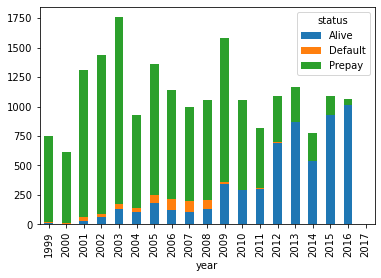

In [47]:
## Using plotly to create bar chart to represent the data
import matplotlib.pyplot as plt
%matplotlib inline
FM2.plot.bar(stacked=True)

#### Comment on the change in mortgage behavior through the mortgage origination cycle.

We are likely to see more and more prepayments (or defaults) as the mortgages age, as consumers may see value in switching (or default if they're unable to pay the installments), as the economic conditions change. Thus we see very few old loans alive, while most of the recent ones are still active.

## Q3 Analyse Mortgage Statuses
#### Repeat the analysis above but instead of grouping the mortgages by first_pmt_date, group them by age. 

<AxesSubplot:xlabel='age'>

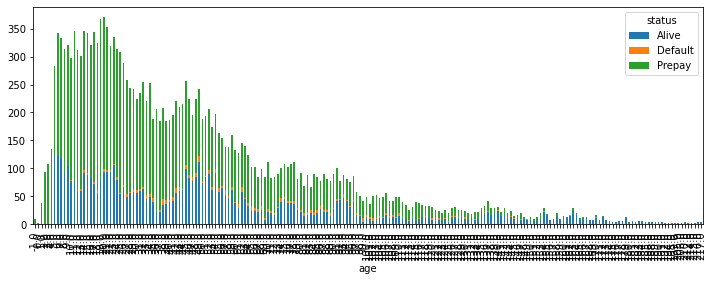

In [48]:
## Create a pivot table with 'age' and 'status', & then display in graph
FM3 = pd.pivot_table(FM, index='age', columns='status', aggfunc=len, values='loan_seq_num', fill_value=0)
FM3.plot.bar(stacked=True)

#### In addition, briefly explain how you may go about building prepayment and default models for residential mortgages. What data will be required if we want to build such models for Unison home equity agreements (UEA)?

To build a prepayment and/or default model, we need to consider which factors play a part in changing the status of a mortgage from 'Alive' to either 'Prepay' or 'Default'. The same can be achieved through logistic regression. We can also look at the CPR(t) - the conditional prepayment rate - to build the model dependent on these factors such as interest rate, fico score etc.

For Unison Home Equity Agreements (UEA), apart from the given factors, we may also need the data related to 
* Home prices (for e.g. HPI - Home Price Index), as higher prices also act as an incentive for borrowers to go for higher mortgage or selling the property. 
* Economic Indicators like GDP growth rate, unemployment rate etc. A booming economy would lead to higher turnover in residential homes, as owners may want to expand or move to a better location/house. 

## Q4 Unconditional Probabilities of Mortgage Behavior
#### Determine the unconditional probabilities of mortgage behavior based on the sample data and describe how you arrive at your results.

We are looking at the probability of a mortgage either defaulting, prepaying or staying alive in 5 years. Since these are the only 3 possibilities, the total of these probabilities must be 1.
To look for unconditional probability, we need to make the following changes:
* Remove all loans which are alive and have age less than 5 years (60 months) - Since we do not know about the end state (at 5 years) of the loan which is alive at age 2 years, we need to remove such loans from the dataset.
* Change status of all loans above 5 years to 'Alive' - The loans marked 'Prepay' or 'Default' after 5 years would all be alive at the end of 5 years.

<AxesSubplot:ylabel='status'>

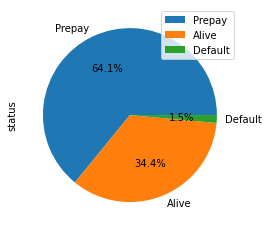

In [64]:
## Remove loans where 'age'<60 & 'status'=='Alive'
FM4 = FM[-((FM['age']<60) & (FM['status']=='Alive'))]

## Change status of all loans where 'age'>60 to 'Alive'
FM4.loc[FM['age']>60, 'status'] = 'Alive'

## Create a count of all loans and normalize to get the proportion status count
FM4s = pd.DataFrame(FM4['status'].value_counts(normalize=True))

FM4s.plot.pie(y='status', autopct='%1.1f%%')

#### How could prepayment or default behavior of the mortgage affect the Unison equity agreement (UEA) on the same home? 

A prepayment may be refinance due to lower rates or cash-out, which imply a rise in house price. In case of turnover as well, the borrower will also prepay and close the loan. All these scenarios are beneficial for Unison as the Equity value in the house goes up, which stands to benefit both Unison and UEA holder.
Default on the other hand signifies an economic hardship, which may result in a distress sale or auction of property by lender. Such an event would negatively impact the value of house, and the return for Unison in the UEA.

## Q5 Prepayment Model
#### Select one or more factors which you believe would affect the 'Prepay' response and build a simple model to predict prepayment or default rates

I'm building a model for Prepayment, in which case prepayment would signify 1 while Alive or Default would be 0 in the logistic regression. The dummy variables would also need to be created for categorical columns. We can run an 

In [50]:
# We need to carry out logistic regression here for prepayment, so need a Y=1 for 'Prepay' and 0 else
FM['Y'] = 0
FM.loc[FM['status']=='Prepay','Y'] = 1

In [51]:
## import libraries to run logistic regression
import scipy
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
import statsmodels.api as sm
from scipy import stats

In [52]:
## Choose appropriate columns for logistic regression
FM5 = FM[['age', 'first_time_ho_flag', 'credit_score', 'occupancy_status', 'orig_cltv', 'orig_dti', 'orig_ir', 'prop_type', 'loan_purpose', 'num_borrowers', 'Y']]

## Columns which need to be converted to numbers from string
Num_col = ['orig_cltv', 'orig_dti', 'orig_ir']
for col in Num_col:
    FM5[col] = pd.to_numeric(FM5[col], errors='coerce')
FM5 = FM5.dropna()
# print(FM5.shape)

In [53]:
# Remove space from other columns with strings
FM5 = FM5.replace(r'^\s*$', np.NaN, regex=True)
FM5 = FM5.dropna()
# print(FM5.shape)

catColumns = FM5.select_dtypes(['object']).columns
# Create Dummy variables for categorical values
FM5 = pd.get_dummies(data=FM5, columns=catColumns, drop_first=True)
# print(FM5.shape)

In [63]:
## Run OLS regression to get variables info to use or discard
FM5_X = FM5.loc[:, FM5.columns != 'Y']
FM5_y = FM5.loc[:, 'Y']

X2 = sm.add_constant(FM5_X)
est = sm.OLS(FM5_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     377.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:53:32   Log-Likelihood:                -5051.6
No. Observations:               13188   AIC:                         1.014e+04
Df Residuals:                   13171   BIC:                         1.026e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7381 

Looking at the t-stats for above variables, we can discard prop_type and consider everything else in the model. This just indicates that property type does not significantly impact the decision to prepay a loan. The most significant factors, from the above, are interest rates, loan age and credit score, which are usually quoted as major factors for borrower behaviour. We can now run a logistic regression, the score of which will be displayed at the end. A high score denotes how well the model is performing.

In [57]:
## Combining various Categorical variables to the final model 
col0 = ['age', 'credit_score', 'orig_cltv', 'orig_dti', 'orig_ir', 'num_borrowers']
FTHF = ['first_time_ho_flag_Y']
OS = ['occupancy_status_O', 'occupancy_status_S']
PT = ['prop_type_CP', 'prop_type_LH', 'prop_type_MH', 'prop_type_PU', 'prop_type_SF']
LP = ['loan_purpose_N', 'loan_purpose_P']

colx = col0 + FTHF + OS + LP
#colx= col0

FM5_X = FM5.loc[:, colx]
FM5_y = FM5.loc[:,'Y']
#print(FM5.mean())

In [58]:
## Regression
clf = LogisticRegression(random_state=0).fit(FM5_X, FM5_y)
clf.predict_proba(FM5_X)
clf.score(FM5_X, FM5_y)

print('Logistic Model Score: ', clf.score(FM5_X, FM5_y))

Logistic Model Score:  0.83128601759175


The following conusion matrix shows the performance of the model vs the actual prepayments.

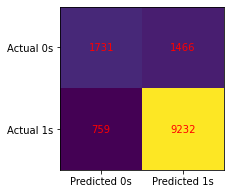

In [62]:
## Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(FM5_y, clf.predict(FM5_X))

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

#### Comment on how your selected response (prepayment or default) might affect the market price of a mortgage and how you could devise an investment strategy around this model’s output. 

By building the model, we can predict the cashflows of the mortgage. These cashflows discounted back would then be used to arrive at the value of the mortgage. If the model is good, we can identify the mortgages (MBS/MSR) which are mispriced, earning an arbitrage in the process. 

## Q6 Why monitoring is essential for Unison  
#### Why do you think we need to monitor, analyze and understand the mortgage industry in general and our customers’ mortgages in particular?

By buying borrower's equity, Unison is a party to the performance of home equity. The mortgage may be a lead indicator, and the preformance of mortgage and its behavior can tell us whether ur investment is doing well or poorly, and allow us to manage our risk better. Also, a good borrower is required for both mortgage as well as UEA, as a major risk is tied to the economic condition of the borrower. Analyzing these factors would improve our portfolio performance and mitigage the risk.  

#### Name key metrics that you believe are good indicators of risk and explain how you think we can use those metrics in risk management, investment structuring, etc.

The major risk indicators are:
1. Housing prices - since we're buying home equity, this becomes the primary risk for the portfolio.
2. Economic conditions (GDP growth rate, unemployment rate, inflation/interest rate) - these macro factors can help us in determining whether the returns expected on the portfolio are good or bad.
3. Borrower characteristics (fico score, 